In [1]:
from tqdm import tqdm
import os
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

In [3]:
model_seqs = pd.read_parquet('../data/interim/filtered_model_seqs.pq')

## DefenseFinder domains

First we'll extract the a3ms from the defense finder database

In [8]:
df_a3m_dir = '../data/interim/df_a3ms/'
if 'df_a3ms' not in os.listdir('../data/interim/'):
    os.mkdir(df_a3m_dir)

In [9]:
df_name_mapping = []
first = True
for line in tqdm(open(os.path.expanduser('~/Documents/hhpred/data/hhsuite_dbs/df/df_a3m.ffdata'), 'r')):
    if first:
        a3m_file = df_a3m_dir + line.split(' ')[0][1:] + '.a3m'
        df_name_mapping.append({'seq_id': line.split(' ')[0][1:], 
                                'defense_id': line.split(' ')[1]})
        out_file = open(a3m_file, 'w')
        out_file.write(line)
        first=False
    elif '~' in line:
        a3m_file = df_a3m_dir + line.split(' ')[0][2:] + '.a3m'
        df_name_mapping.append({'seq_id': line.split(' ')[0][2:], 
                                'defense_id': line.split(' ')[1]})
        out_file = open(a3m_file, 'w')
        out_file.write(line[1:])
    else:
        out_file.write(line)
out_file.close()

3114429it [00:16, 188917.80it/s]


In [10]:
df_name_mapping_df = pd.DataFrame(df_name_mapping)

In [11]:
df_raw_out_dir = '../data/interim/df_pfam_innate_alignments/'
df_parsed_out_file = '../data/interim/df_pfam_innate_domains.csv'

In [6]:
os.system(' '.join(['conda run -n hhpred python',
                    '~/Documents/hhpred/code/hhpred.py',
                    df_raw_out_dir,
                    df_parsed_out_file, 
                    '--dbs pfam innate',
                    '--input_a3m_dir', 
                    df_a3m_dir]))

Using pre-built alignments in ../data/interim/df_a3ms/
Querying pfam, innate database(s)



100%|██████████| 1098/1098 [04:18<00:00,  4.25it/s]
Traceback (most recent call last):
  File "/home/gridsan/pdeweirdt/Documents/hhpred/code/hhpred.py", line 214, in <module>
    hhpred(args.in_fasta, args.raw_out_dir, args.parsed_out_file, args.dbs)
  File "/home/gridsan/pdeweirdt/Documents/hhpred/code/hhpred.py", line 121, in hhpred
    if os.path.isdir(raw_out_dir):
  File "/home/gridsan/pdeweirdt/.conda/envs/hhpred/lib/python3.9/genericpath.py", line 42, in isdir
    st = os.stat(s)
TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

ERROR conda.cli.main_run:execute(47): `conda run python /home/gridsan/pdeweirdt/Documents/hhpred/code/hhpred.py ../data/interim/df_pfam_innate_alignments/ ../data/interim/df_pfam_innate_domains.txt --dbs pfam innate --input_a3m_dir ../data/interim/df_a3ms/` failed. (See above for error)


256

In [12]:
defense_finder_pfam_domains = pd.read_csv('../data/interim/df_pfam_innate_domains.csv')

In [13]:
defense_finder_pfam_domains = (defense_finder_pfam_domains.merge(df_name_mapping_df, left_on='query', right_on='seq_id'))

In [14]:
prob_cutoff = 50

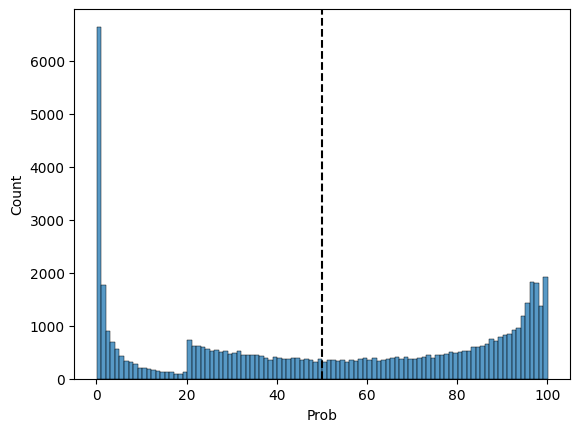

In [15]:
sns.histplot(defense_finder_pfam_domains['Prob'], binwidth=1)
plt.axvline(prob_cutoff, linestyle='dashed', color='black')

In [16]:
defense_finder_pfam_domains['pfam_id'] = [x.strip() for x in defense_finder_pfam_domains['Hit'].str.split('.', expand=True)[0]]
defense_finder_pfam_domains = defense_finder_pfam_domains.merge(pfam_clans, how='left', on='pfam_id')

In [17]:
pfam_clans['clan_name'].value_counts().head(30)

clan_name
HTH               456
TPR               367
E-set             363
NADP_Rossmann     268
P-loop_NTPase     258
TIM_barrel        185
Beta_propeller    165
SH3               157
PDDEXK            154
OB                136
MBB               128
Zn_Beta_Ribbon    101
PH                 98
Ubiquitin          90
Hybrid             89
GBD                89
Peptidase_CA       84
RNase_H            78
AB_hydrolase       78
Peptidase_MA       77
RING               74
Cupin              72
Thioredoxin        68
C2H2-zf            66
Concanavalin       63
GT-A               56
GT-B               55
GPCR_A             53
NTF2               53
Met_repress        52
Name: count, dtype: int64

In [18]:
pfam_max_prob = defense_finder_pfam_domains.groupby('Hit').agg({'Prob': 'max'}).reset_index()
pfam_max_prob['pfam_id'] = [x.strip() for x in pfam_max_prob['Hit'].str.split('.', expand=True)[0]]
pfam_max_prob = (pfam_max_prob.merge(pfam_clans, how='left', on='pfam_id'))

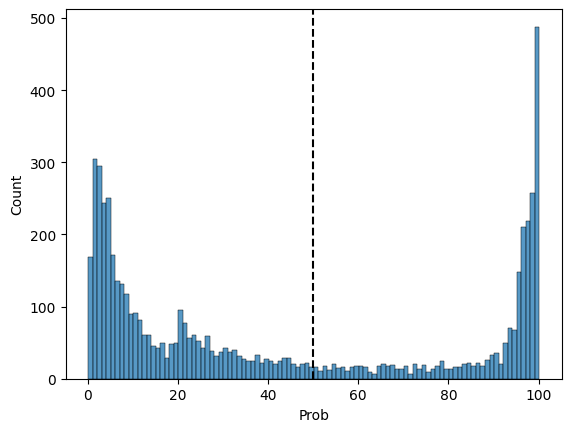

In [19]:
sns.histplot(pfam_max_prob['Prob'], binwidth=1)
plt.axvline(prob_cutoff, linestyle='dashed', color='black')

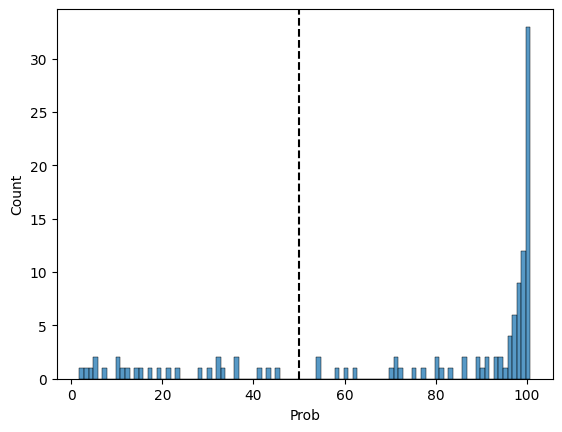

In [20]:
sns.histplot(pfam_max_prob.loc[pfam_max_prob['clan_name'] == 'PDDEXK', 'Prob'], binwidth=1)
plt.axvline(prob_cutoff, linestyle='dashed', color='black')

In [21]:
defense_finder_pfam_domains['E-value_root'] = np.power(defense_finder_pfam_domains['E-value'], 1/10)

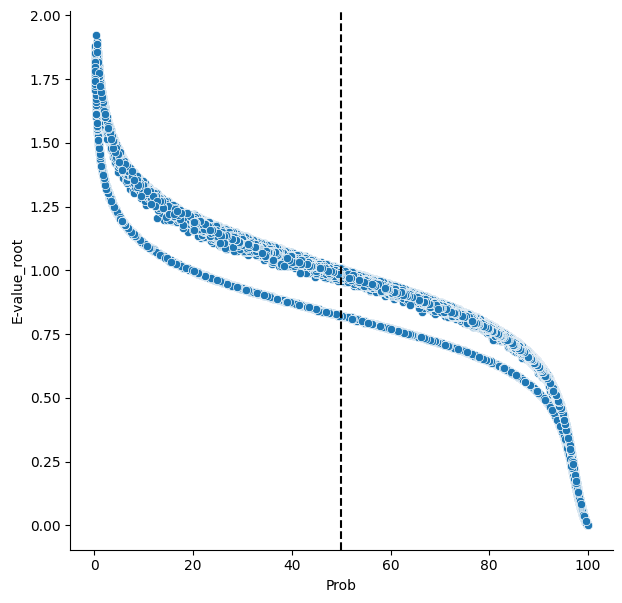

In [22]:
plt.subplots(figsize=(7,7))
sns.scatterplot(data=defense_finder_pfam_domains, x='Prob', y='E-value_root')
sns.despine()
plt.axvline(prob_cutoff, linestyle='dashed', color='black')

In [23]:
filtered_domains = (defense_finder_pfam_domains[defense_finder_pfam_domains['Prob'] > prob_cutoff]
                    .sort_values('Prob', ascending=False)
                    .groupby(['defense_id', 'Hit'])
                    .head(1))

In [24]:
wide_domains = (filtered_domains.pivot(index='defense_id', values='Prob', columns='Hit')
                .fillna(0))

/home/gridsan/pdeweirdt/.conda/envs/beaker/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/gridsan/pdeweirdt/.conda/envs/beaker/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


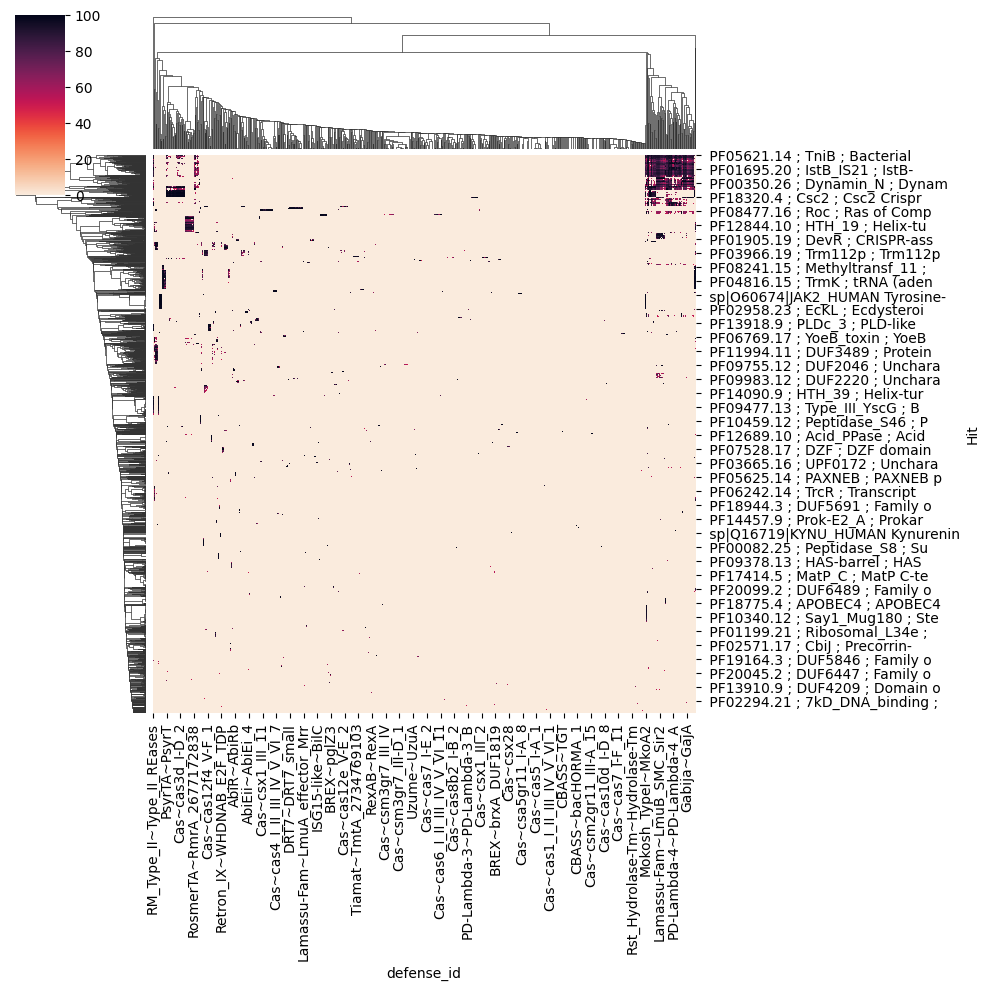

In [25]:
sns.clustermap(wide_domains.T, cmap='rocket_r')


In [26]:
blacklisted_domains = (defense_finder_pfam_domains[defense_finder_pfam_domains['Prob'] > prob_cutoff]
                    .sort_values('Prob', ascending=False)
                    .groupby(['Hit'])
                    .head(1))

In [27]:
blacklisted_domains['clan_name'].value_counts().head(20)

clan_name
HTH                241
P-loop_NTPase      210
NADP_Rossmann      136
TPR                 96
PDDEXK              91
AB_hydrolase        65
Zn_Beta_Ribbon      50
Peptidase_MA        31
NTF2                27
Met_repress         26
PKinase             24
NTP_transf          23
Peptidase_PA        22
HAD                 22
4Fe-4S              20
TIM_barrel          20
CDA                 18
KNTase_C            17
vWA-like            17
RAMPS-Cas5-like     16
Name: count, dtype: int64

## Output

In [31]:
blacklisted_domains.to_csv('../data/interim/df_blacklisted_domains.csv', index=False)